In [34]:
library(tidyverse)
library(lubridate)
library(rgdal)
library(pointdensityP)
library(scales)
library(sf)

### Data Import; Variable Descriptions

In [6]:
setwd("C:/Users/Lyllian/Desktop/chicago_traffic")

In [27]:
traffic = read.csv("chicagotraffic2019.csv")
vehicles = read.csv("chicagovehicles.csv")
chicagobounds = readOGR("city_bounds",
                        layer = "geo_export_4cbb768f-bdbb-49c8-87e4-aab02d3f1951")

Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
"Discarded datum WGS84 in Proj4 definition: +proj=longlat +ellps=WGS84 +no_defs"


OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\Lyllian\Desktop\chicago_traffic\city_bounds", layer: "geo_export_4cbb768f-bdbb-49c8-87e4-aab02d3f1951"
with 1 features
It has 4 fields


> The `traffic` dataset is the main one that we'll use to answer our exploratory questions. It was retrieved from the Stats 306 Canvas page. This data contains information about recorded car crashes in the city of Chicago for the year 2019, with crashes being identifiable by their unique record id.

**Variables:**

* `crash_record_id`: unique record id number for each accident; matches the `vehicle` variable
* `street_direction`: street address direction for the street the crash occurred on (N, S, E, or W)
* `street_name`: name of street the crash occurred on
* `latitude` & `longitude`: coordinates of where incident occurred

The two remaining datasets were sourced directly from the Chicago Data Portal:

> The `vehicles` *csv* file contains more detailed information about the cars involved in the crash reports from the `traffic` dataset and are joined by the `crash_record_id` variable. (https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)

> The `chicagobounds` shapefile contains spatial data relating to the boundaries of the city of Chicago; this is used to place spatial data in the context of city bounds. (https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-City/ewy2-6yfk)

### Data Tidying

In [28]:
chicago = vehicles %>% inner_join(traffic, by = "CRASH_RECORD_ID") # joining datasets

chicagotidy = chicago %>% 
    select(CRASH_DATE.x, VEHICLE_ID, LIC_PLATE_STATE, VEHICLE_TYPE, WEATHER_CONDITION, LIGHTING_CONDITION, DAMAGE, 
            PRIM_CONTRIBUTORY_CAUSE, STREET_DIRECTION, STREET_NAME, MOST_SEVERE_INJURY, LATITUDE, LONGITUDE, 
           DATE_POLICE_NOTIFIED, CRASH_RECORD_ID) %>%
    mutate(CRASH_DATE = mdy_hms(CRASH_DATE.x), DATE_NOTIFIED = mdy_hms(DATE_POLICE_NOTIFIED)) %>%
    mutate_if(is.factor, as.character)

chicagotidy = chicagotidy %>% select(-CRASH_DATE.x, -DATE_POLICE_NOTIFIED) %>% 
    mutate_if(is.character, str_to_lower) %>% select(CRASH_DATE, everything())
names(chicagotidy) = tolower(names(chicagotidy))
head(chicagotidy)
glimpse(chicagotidy)

,crash_date,vehicle_id,lic_plate_state,vehicle_type,weather_condition,lighting_condition,damage,prim_contributory_cause,street_direction,street_name,most_severe_injury,latitude,longitude,crash_record_id,date_notified
,<dttm>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dttm>
1,2019-09-28 03:30:00,834816,il,passenger,rain,darkness,"over $1,500",unable to determine,n,laramie ave,no indication of injury,41.90004,-87.75558,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554932773284e51271e820d7a3c2398fa53636ac3b5b9004d27ee725ff26cfe65ce9b7869b67572e8f17d,2019-09-28 06:13:00
2,2019-09-28 03:30:00,834819,il,unknown/na,rain,darkness,"over $1,500",unable to determine,n,laramie ave,no indication of injury,41.90004,-87.75558,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554932773284e51271e820d7a3c2398fa53636ac3b5b9004d27ee725ff26cfe65ce9b7869b67572e8f17d,2019-09-28 06:13:00
3,2019-09-28 03:30:00,834817,il,unknown/na,rain,darkness,"over $1,500",unable to determine,n,laramie ave,no indication of injury,41.90004,-87.75558,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554932773284e51271e820d7a3c2398fa53636ac3b5b9004d27ee725ff26cfe65ce9b7869b67572e8f17d,2019-09-28 06:13:00
4,2019-10-22 15:00:00,837379,il,passenger,unknown,daylight,"over $1,500",following too closely,s,vincennes ave,no indication of injury,41.75621,-87.63213,3d04e4204397532ccd7bf9927c04609b0828055e7b2ed694140e469b48272587ce731f2752f0abceabb8ba6fbabc3f486b89fbee56fbd3b51e87509867a48421,2020-05-12 11:36:00
5,2019-10-22 15:00:00,837380,,unknown/na,unknown,daylight,"over $1,500",following too closely,s,vincennes ave,no indication of injury,41.75621,-87.63213,3d04e4204397532ccd7bf9927c04609b0828055e7b2ed694140e469b48272587ce731f2752f0abceabb8ba6fbabc3f486b89fbee56fbd3b51e87509867a48421,2020-05-12 11:36:00
6,2019-08-26 19:30:00,689491,il,unknown/na,clear,dusk,$500 or less,failing to reduce speed to avoid crash,s,hamilton ave,no indication of injury,41.75192,-87.67697,d60cc564dfb07257f5425ffcd018e3c7c76f729757d25126a0477982b24f0a28d025f08db876ec7ac97820c6df11ef737130250b59f64b86bed0473d54852a2d,2019-08-26 20:02:00


Rows: 240,159
Columns: 15
$ crash_date              <dttm> 2019-09-28 03:30:00, 2019-09-28 03:30:00, 201~
$ vehicle_id              <int> 834816, 834819, 834817, 837379, 837380, 689491~
$ lic_plate_state         <chr> "il", "il", "il", "il", "", "il", "il", "il", ~
$ vehicle_type            <chr> "passenger", "unknown/na", "unknown/na", "pass~
$ weather_condition       <chr> "rain", "rain", "rain", "unknown", "unknown", ~
$ lighting_condition      <chr> "darkness", "darkness", "darkness", "daylight"~
$ damage                  <chr> "over $1,500", "over $1,500", "over $1,500", "~
$ prim_contributory_cause <chr> "unable to determine", "unable to determine", ~
$ street_direction        <chr> "n", "n", "n", "s", "s", "s", "w", "n", "s", "~
$ street_name             <chr> "laramie ave", "laramie ave", "laramie ave", "~
$ most_severe_injury      <chr> "no indication of injury", "no indication of i~
$ latitude                <dbl> 41.90004, 41.90004, 41.90004, 41.75621, 41.756~
$ longitude   

### Spatial Trends for Car Crashes
**Are there any specific locations in Chicago where crashes are more prone to occur? Are these locations related to popular landmarks/areas or any particular street?**

*Transforming Data*

Since we're interested in crash density patterns by location, we'll want to keep our location variables like latitude and longitude, and street_name and street_direction. We'll also want a function that will calculate the density at each point, and we want to store this data to access throughout our analysis. The initial density spread was extremely skewed based on the 5-point summary created. If we want to get a better understanding of how these density trends vary by location, it could helpful to standardize the density scores on a scale from 0 to 1.

In [11]:
mapsdata = chicagotidy %>% filter(latitude != 0, longitude != 0) %>% 
    select(latitude, longitude, street_name, street_direction, crash_date)
head(mapsdata)
chicagobounds = fortify(chicagobounds)
head(chicagobounds)
chicagodensity = data.frame(pointdensity(mapsdata, "latitude", "longitude", "crash_date", 0.1, 0.2))
chicagodensity = chicagodensity %>% mutate(stndcount = rescale(count, c(0,1), range(count)))
head(chicagodensity); summary(chicagodensity)

,latitude,longitude,street_name,street_direction,crash_date
,<dbl>,<dbl>,<chr>,<chr>,<dttm>
1,41.90004,-87.75558,laramie ave,n,2019-09-28 03:30:00
2,41.90004,-87.75558,laramie ave,n,2019-09-28 03:30:00
3,41.90004,-87.75558,laramie ave,n,2019-09-28 03:30:00
4,41.75621,-87.63213,vincennes ave,s,2019-10-22 15:00:00
5,41.75621,-87.63213,vincennes ave,s,2019-10-22 15:00:00
6,41.75192,-87.67697,hamilton ave,s,2019-08-26 19:30:00


Regions defined for each Polygons



,long,lat,order,hole,piece,id,group
,<dbl>,<dbl>,<int>,<lgl>,<fct>,<chr>,<fct>
1,-87.93514,42.00089,1,FALSE,1,0,0.1
2,-87.93509,42.00094,2,FALSE,1,0,0.1
3,-87.93517,42.00333,3,FALSE,1,0,0.1
4,-87.93519,42.00430,4,FALSE,1,0,0.1
5,-87.93521,42.00491,5,FALSE,1,0,0.1
6,-87.93523,42.00573,6,FALSE,1,0,0.1



The radius was adjusted to  0.2224 km in order to accomodate the grid size


The grid size is  0.001  measured in degrees

There are  27272  unique grids that require  681800  measurements...

  |======================================================================| 100%done...



,lat,lon,count,dateavg,stndcount
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,41.65375,-87.53268,1,18124,0
2,41.66322,-87.59775,1,18031,0
3,41.67484,-87.65662,1,18065,0
4,41.67717,-87.54017,1,17962,0
5,41.67827,-87.60140,1,18159,0
6,41.68391,-87.72975,1,17905,0


      lat             lon             count          dateavg     
 Min.   :41.64   Min.   :-87.93   Min.   :  1.0   Min.   :17898  
 1st Qu.:41.79   1st Qu.:-87.72   1st Qu.: 50.0   1st Qu.:18069  
 Median :41.88   Median :-87.68   Median : 91.0   Median :18081  
 Mean   :41.86   Mean   :-87.68   Mean   :123.7   Mean   :18081  
 3rd Qu.:41.93   3rd Qu.:-87.63   3rd Qu.:159.0   3rd Qu.:18092  
 Max.   :42.02   Max.   :-87.52   Max.   :826.0   Max.   :18261  
   stndcount      
 Min.   :0.00000  
 1st Qu.:0.05939  
 Median :0.10909  
 Mean   :0.14872  
 3rd Qu.:0.19152  
 Max.   :1.00000  

*General Density Map*

Now that we've converted the chicagobounds shapefile to a dataset, we can use it in our ggplot to create the outline of the city of Chicago. Since the range of the stndcount densities are much more condensed than the original count densities, we can use these to group our crash observations. To reflect the still skewed distribution, we'll just want to make sure to have the color gradient values mirror the 5-point summary values we created.

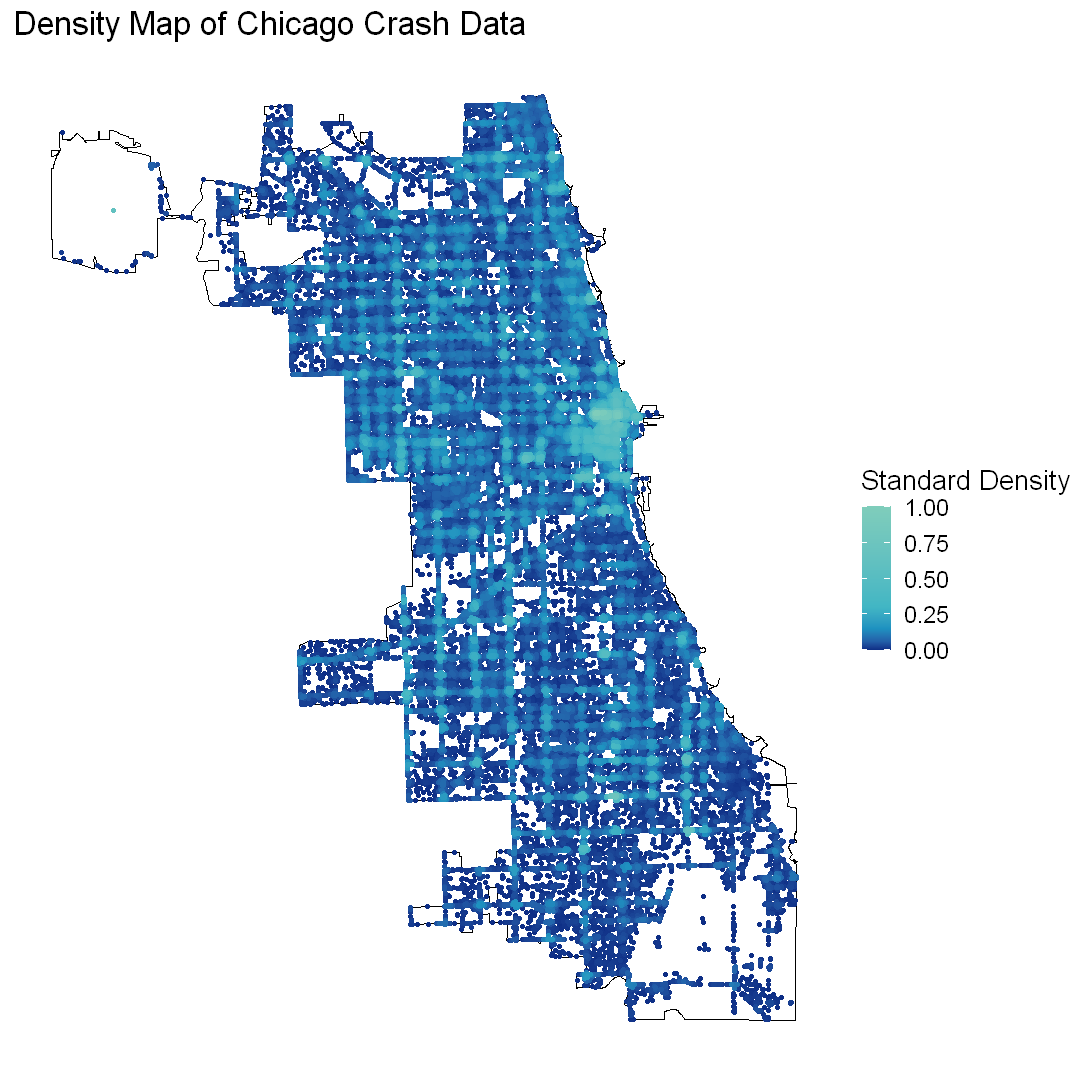

In [12]:
options(repr.plot.width = 9, repr.plot.height = 9)
ggplot() +
    geom_path(data = chicagobounds, aes(long, lat, group = group)) +
    geom_point(data = chicagodensity, aes(lon, lat, colour = stndcount), size = 1) +
    scale_color_gradientn(name = "Standard Density",
                          colors = c('#0c2c84','#225ea8','#1d91c0','#41b6c4','#7fcdbb'), 
                          values = c(0, 0.06, 0.15, 0.3, 1)) +
    labs(title = "Density Map of Chicago Crash Data") +
    theme(panel.background = element_blank(),
            axis.ticks = element_blank(),
            axis.text = element_blank(),
            axis.title = element_blank(),
            plot.title = element_text(size = 20),
            legend.text = element_text(size = 14),
            legend.title = element_text(size = 16))

*Zooming in on densest area*

Warning message:
"Removed 11307 row(s) containing missing values (geom_path)."


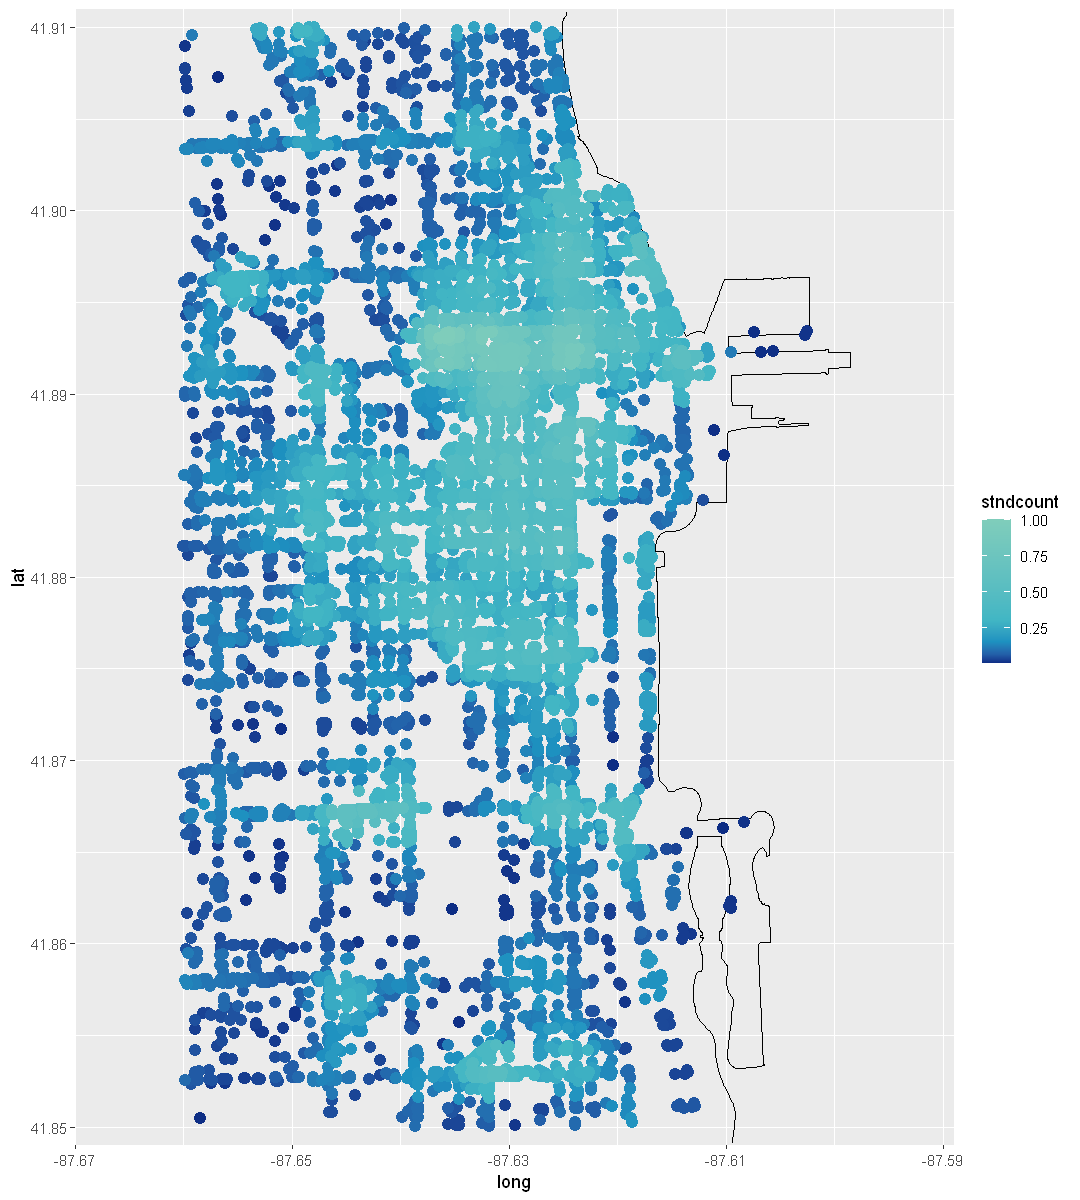

In [13]:
densearea = chicagodensity %>% filter(lat > 41.85, lat < 41.91, lon > -87.66, lon < -87.59)
options(repr.plot.width = 9, repr.plot.height = 10)
ggplot() +
    geom_path(data = chicagobounds, aes(long, lat, group = group)) +
    geom_point(data = densearea, aes(lon, lat, colour = stndcount), size = 3) +
    scale_x_continuous(limits = c(-87.67, -87.589), expand = expansion(add = 0)) +
    scale_y_continuous(limits = c(41.849, 41.911), expand = expansion(add = 0)) +
    scale_color_gradientn(colors = c('#0c2c84','#225ea8','#1d91c0','#41b6c4','#7fcdbb'), values = c(0, 0.06, 0.15, 0.3, 1))

*Further Exploration of Densities with Street Data*

Here we're writing a function that estimates the coordinates of the beginning and end of a street based on latitude, longitude, and street direction data and then creates a line that should roughly correspond to that street when plotted with our original Chicago map. Most streets in Chicago either run vertically or horizontally, so we should be able to approximate the start and end coordinates of each street based on its direction (N or S vs E or W) and maximum/minimum latitude/longitude values. Once we have these points we can use them to create a line corresponding to each street.

In [16]:
streetcoords = function(s, type) {
  coords = mapsdata %>% filter(street_name == s) %>% select(street_name, longitude, latitude, street_direction)
  if (str_extract(coords[1,4], "[a-z]") == "s"| str_extract(coords[1,4], "[a-z]") == "n") {
    maxcoord = c(coords %>% arrange(latitude) %>% select(longitude, latitude) %>% slice(1) %>% as.numeric())
    mincoord = c(coords %>% arrange(desc(latitude)) %>% select(longitude, latitude) %>% slice(1) %>% as.numeric())
    latlon = unlist(c(mincoord, maxcoord))
  }
  else {
    maxcoord = c(coords %>% arrange(longitude) %>% select(longitude, latitude) %>% slice(1) %>% as.numeric())
    mincoord = c(coords %>% arrange(desc(longitude)) %>% select(longitude, latitude) %>% slice(1) %>% as.numeric())
    latlon = unlist(c(mincoord, maxcoord))
  }
    names(latlon) = c("x", "y", "xend", "yend")
    switch(
        type,
        street_line = st_linestring(rbind(latlon[1:2], latlon[3:4])),
        street_coord = return(latlon)
    );
}

*Looking at densest areas plotted with most major streets*

Since there are a lot of streets in Chicago, it's probably more reasonable to look at only the major streets and see if they can answer our question about high intersection densities. We can see how the intersection points of these major streets compare to the points with high density (defined based on our 5-point summary). It's easier to define some base variables before iterating through each street pairing, such as a basic plot of Chicago with crash data for the highest density areas, and street vectors for the two streets that intersect. We'll also want to create a data frame for the intersection coordinates from a matrix (since our function for identifying intersections will be returning a matrix with X and Y columns).

In [17]:
majorstreets = mapsdata %>% group_by(street_name) %>% summarize(n = n()) %>% arrange(desc(n)) %>% 
    slice(1:50) %>% select(street_name) %>% as_vector()
names(majorstreets) = NULL
high_density = chicagodensity %>% filter(stndcount > 0.15)
majorstreets; head(high_density)

base = ggplot() + geom_path(data = chicagobounds, aes(x=long, y=lat, group=group)) + 
    geom_point(data = high_density, aes(lon, lat), size = 1.5) +
    labs(title = "High Density Crash Areas and Street Intersections") +
    theme(panel.background = element_blank(),
            axis.ticks = element_blank(),
            axis.text = element_blank(),
            axis.title = element_blank(),
            plot.title = element_text(size = 20))

street1 = c(); street2 = c()
intsxn = as.data.frame(matrix(nrow = 50, ncol = 0))

[1] "western ave"                 "pulaski rd"                 
 [3] "cicero ave"                  "ashland ave"                
 [5] "halsted st"                  "kedzie ave"                 
 [7] "michigan ave"                "north ave"                  
 [9] "clark st"                    "irving park rd"             
[11] "state st"                    "damen ave"                  
[13] "grand ave"                   "belmont ave"                
[15] "california ave"              "archer ave"                 
[17] "fullerton ave"               "central ave"                
[19] "stony island ave"            "chicago ave"                
[21] "madison st"                  "87th st"                    
[23] "milwaukee ave"               "addison st"                 
[25] "roosevelt rd"                "63rd st"                    
[27] "cottage grove ave"           "79th st"                    
[29] "dr martin luther king jr dr" "division st"                
[31] "95th st"                     "lake shore dr nb"           
[33] "47th st"                     "devon ave"                  
[35] "foster ave"                  "cermak rd"                  
[37] "lake shore dr sb"            "diversey ave"               
[39] "sheridan rd"                 "lawrence ave"               
[41] "ogden ave"                   "lake st"                    
[43] "harlem ave"                  "montrose ave"               
[45] "lake shore dr"               "kostner ave"                
[47] "lincoln ave"                 "broadway"                   
[49] "laramie ave"                 "elston ave"

,lat,lon,count,dateavg,stndcount
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,41.70739,-87.61850,125,18063.66,0.150303
2,41.70716,-87.61757,125,18063.66,0.150303
3,41.70716,-87.61757,125,18063.66,0.150303
4,41.70714,-87.61824,125,18063.66,0.150303
5,41.70714,-87.61824,125,18063.66,0.150303
6,41.70714,-87.61824,125,18063.66,0.150303


Now we want to plot all the major streets on our Chicago map and identify the intersection points of all of these streets. We use `geom_sf` to plot the linestrings created with our function `streetcoords()`. We then iterate through every possible pair of major streets and identify their intersection points, which will be stored in our empty objects we intialized earlier.

In [21]:
for(i in 1:50) { 
  base = base + geom_sf(data = streetcoords(majorstreets[i], "street_line"), color = "grey41", size = 1)
    
    for(j in 1:50) {
        if(st_intersects(streetcoords(majorstreets[i], "street_line"), 
                         streetcoords(majorstreets[j], "street_line"), sparse = F) == T &
           majorstreets[i] != majorstreets[j]) {
              street1 = c(street1, majorstreets[i])
              street2 = c(street2, majorstreets[j])
              intsxn = rbind(intsxn, st_coordinates(st_intersection(streetcoords(majorstreets[i], "street_line"), 
                      streetcoords(majorstreets[j], "street_line"))))
        }
        else{}
     }
}

We can get an idea of how many of the high density areas occur near intersections by plotting the intersection points on top of the observations with a slightly increased radius.

,street1,street2,X,Y
,<chr>,<chr>,<dbl>,<dbl>
1,western ave,north ave,-87.68731,41.91056
11,western ave,irving park rd,-87.68854,41.95521
12,western ave,grand ave,-87.68716,41.90514
13,western ave,belmont ave,-87.68812,41.93976
14,western ave,archer ave,-87.68522,41.83506
15,western ave,fullerton ave,-87.68770,41.92491


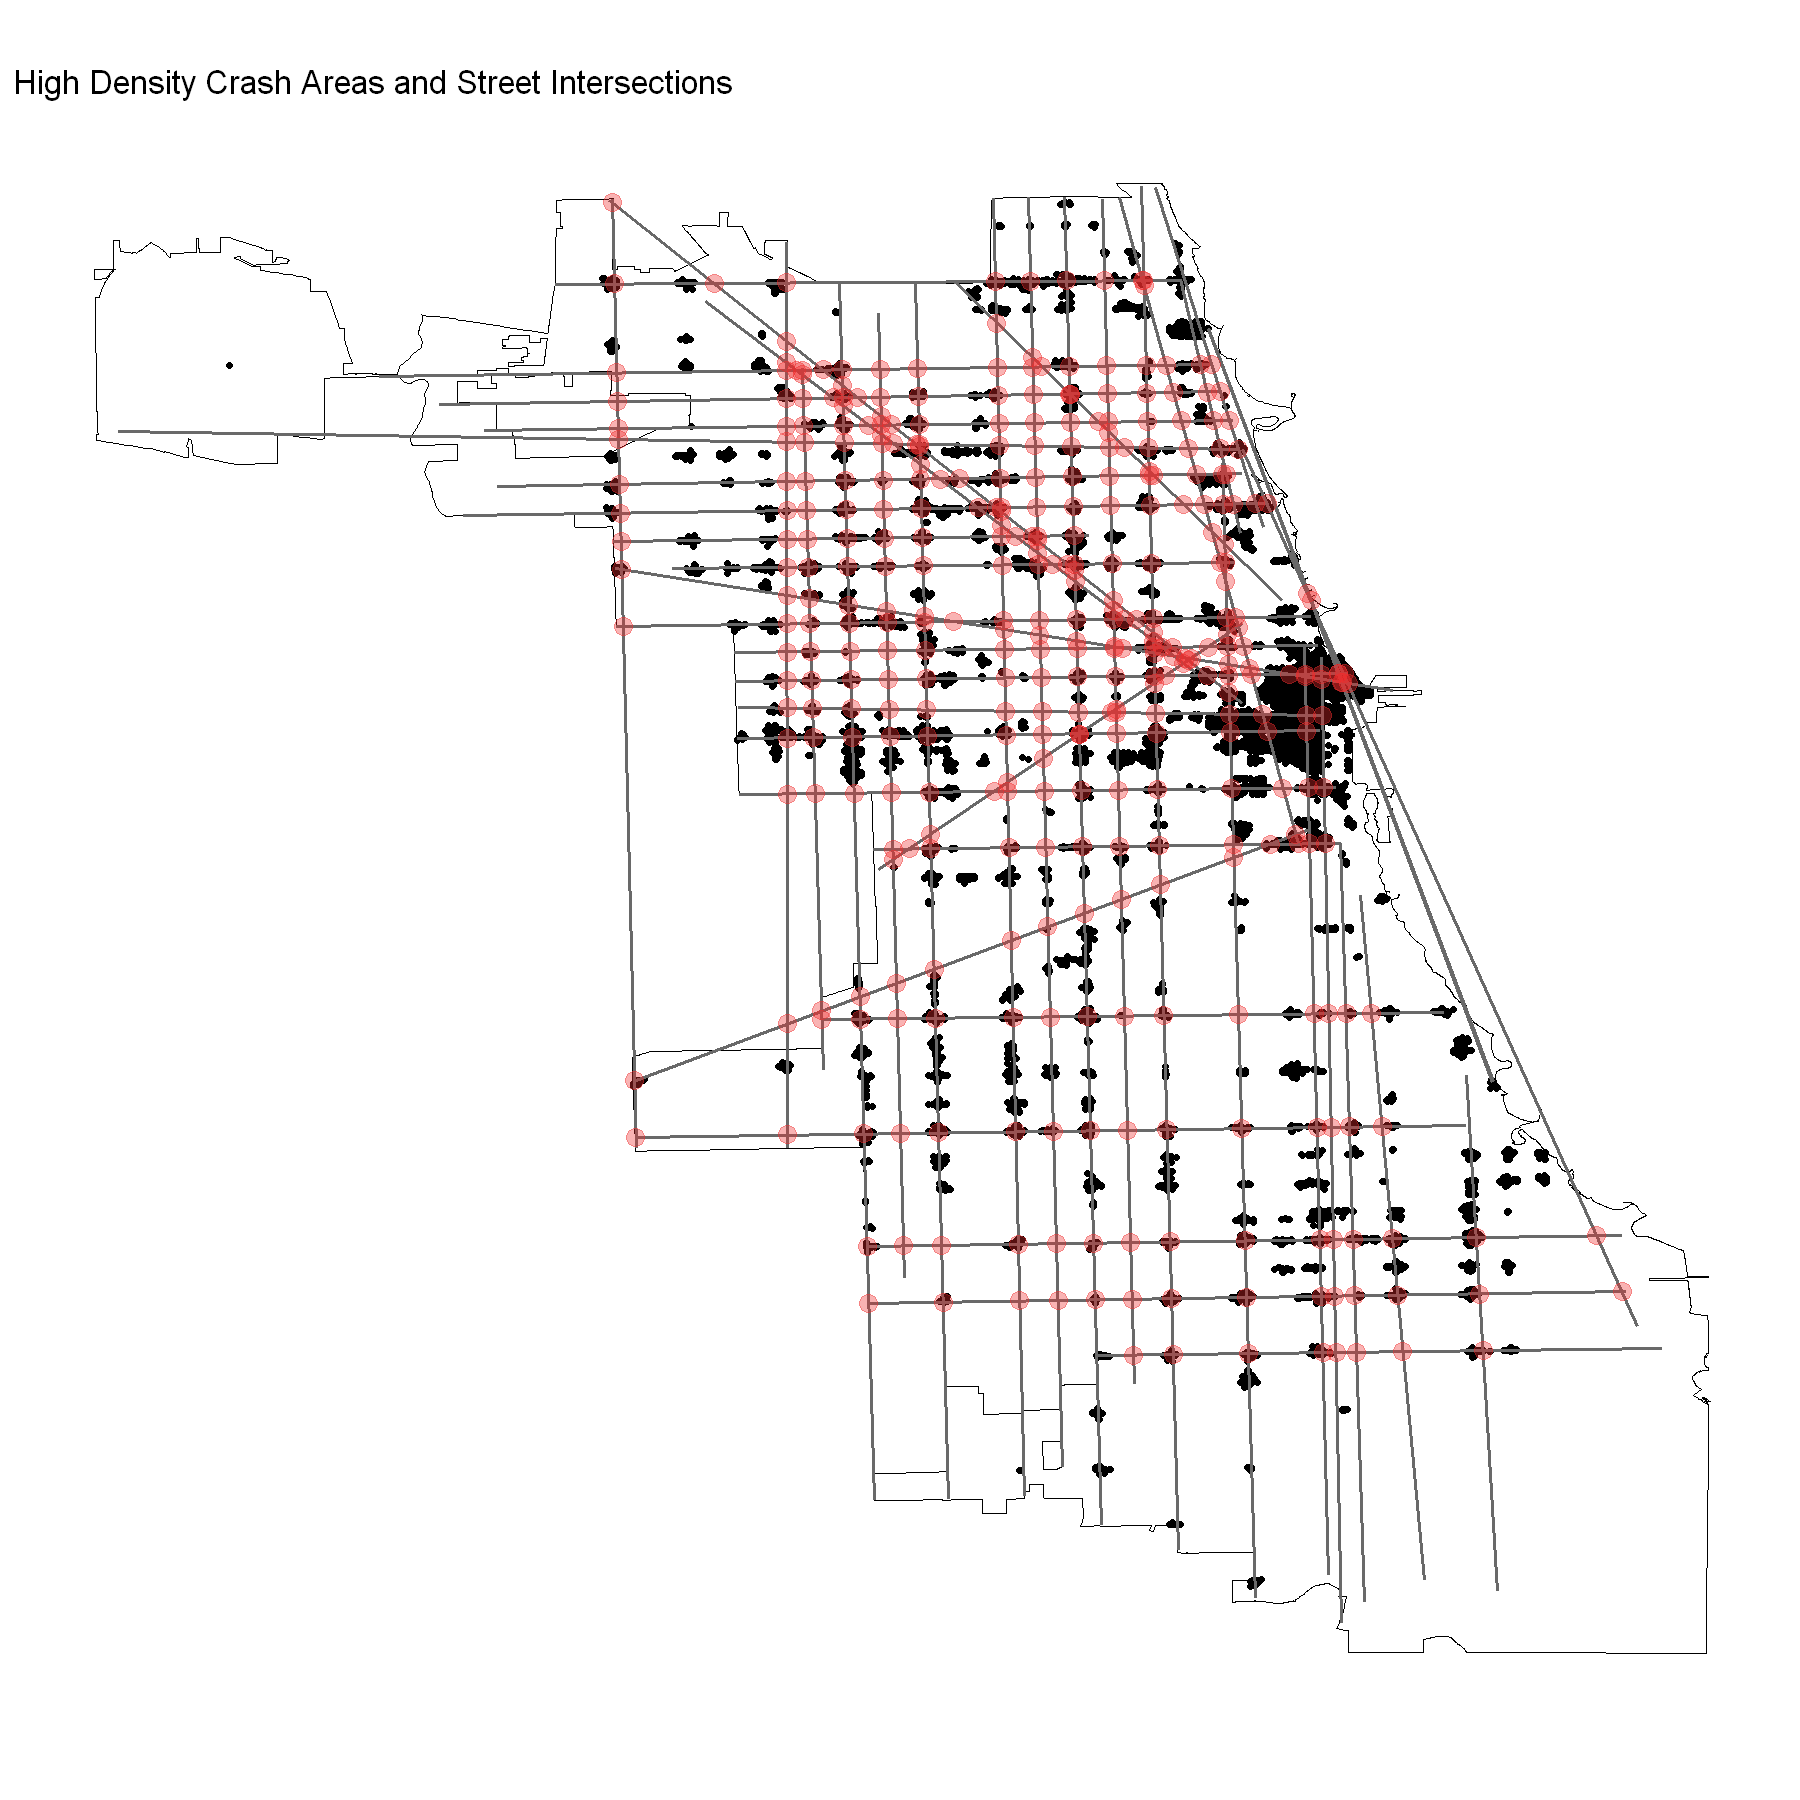

In [22]:
chicagostreets = data.frame(street1, street2, intsxn)
head(chicagostreets)

options(repr.plot.width = 15, repr.plot.height = 15)
base +
    geom_point(data = chicagostreets, aes(X, Y), size = 5, color = "firebrick2", alpha = 0.2)

From the map above, it looks like a lot of crash data overlaps with major street intersections, and this overlap could potentially be greater if we were to plot more street intersection data. The only large area where these major street intersections do not appear to fully explain the high density of crashes is Downtown Chicago, one of the most populated and visited areas of the city. One question we might ask is whether these density trends are related to traffic patterns throughout the day - maybe more crashes happen Downtown and at intersections because they are often heavily dense with traffic at certain times.